[#tidytuesday](https://twitter.com/hashtag/TidyTuesday)
| [Incarceration trends](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-01-22)
| [source](https://github.com/vera-institute/incarceration-trends)

## Dependencies

In [1]:
from collections import Counter
import pandas as pd
from parse import parse
import seaborn as sns
from seaborn import objects as so
from matplotlib import style
import lrdataio

In [2]:
%load_ext watermark
%watermark -iv

matplotlib: 3.6.0
lrdataio  : 0.3.0
seaborn   : 0.12.1
pandas    : 1.4.4



## DataIO

`source_df`

In [3]:
#source_url = 'https://raw.githubusercontent.com/vera-institute/incarceration-trends/master/incarceration_trends.csv'  # noqa
source_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-22/incarceration_trends.csv'  # noqa
source_df = pd.read_csv(lrdataio.cache_url(source_url))

`fips_df`

In [4]:
fips_url = 'https://raw.githubusercontent.com/ljk233/laughingrook-datasets/main/fips/fips_table.csv'  # noqa
fips_df = pd.read_csv(lrdataio.cache_url(fips_url), encoding='cp1252')

## Views

`v_source() -> pd.DataFrame`

In [5]:
def v_source() -> pd.DataFrame:
    return (
        source_df
        .rename(columns={'yfips': 'id', 'fips': 'county_id'})
        .set_index(['county_id', 'year'])
    )

`v_county() -> pd.DataFrame`

In [6]:
def v_county() -> pd.DataFrame:
    return (
        fips_df
        .merge(
            right=source_df[['fips',
                             'capacity',
                             'commuting_zone',
                             'land_area',
                             'metro_area',
                             'num_employees',
                             'urbanicity']],
            left_on='county_id',
            right_on='fips'
        )
        .drop_duplicates()
        .drop(columns='fips')
        .reset_index(drop=True)
    )

`v_crime() -> pd.DataFrame`

In [7]:
def v_crime() -> pd.DataFrame:
    selected_cols = (['county_id', 'year']
                     + [c for c in v_source().columns if '_crime' in c])
    return (
        v_source()[selected_cols]
        .dropna(how='all', subset=selected_cols[2:])
        .rename(columns={c: c.replace('_crime', '') for c in selected_cols})
        .rename(columns={'index': 'crime_index'})
    )

`v_pop() -> pd.DataFrame()` 

In [10]:
def v_pop() -> pd.DataFrame:
    return (
        mv_pcp
        # SELECT ONE OF THE VARIABLES
        .query('variable == "ethnicity"')
        .groupby(['county_id', 'year', 'area'])[['value']].sum()
        .reset_index()
    )

`mv_pcpop`

In [17]:
def _parse_variable(s):
    ls = s.split('_')
    if ls[1] == 'pop':
        ls[1] = 'county'
    if ls[0] in ['male', 'female']:
        ls.append('gender')
    else:
        ls.append('ethnicity')
    return ls[1], ls[-1], ls[0]


selected_cols = [c for c in v_source().columns
                 if ('pop' in c
                     and not ('_adm' in c
                              or '_dcrp' in c
                              or 'total_' in c
                              or 'jail' in c
                              or Counter(c)['_'] == 1))]
mapper = {sc: _parse_variable(sc) for sc in selected_cols}

mv_pcp = (
    v_source()
    .query('year >= 1990')
    [[*mapper.keys()]]
    .melt(var_name='col', ignore_index=False)
    .dropna(subset='value')
    .assign(
        area=lambda x: x['col'].apply(lambda s: mapper[s][0]),
        variable=lambda x: x['col'].apply(lambda s: mapper[s][1]),
        group=lambda x: x['col'].apply(lambda s: mapper[s][2]),
        value=lambda x: x['value'].mul(0.001)
    )
    .sort_values(by=['area', 'variable', 'group'])
    [['area', 'variable', 'group', 'value']]
    .reset_index()
)

,county_id,year,area,variable,group,value
0,1001,1990,county,ethnicity,asian,0.096
1,1001,1991,county,ethnicity,asian,0.102
2,1001,1992,county,ethnicity,asian,0.111
3,1001,1993,county,ethnicity,asian,0.120
4,1001,1994,county,ethnicity,asian,0.126
...,...,...,...,...,...,...
1026201,56041,2014,prison,gender,male,0.031
1026202,56043,2005,prison,gender,male,0.010
1026203,56043,2006,prison,gender,male,0.010
1026204,56043,2007,prison,gender,male,0.010


`v_county_pop() -> pd.DataFrame`

In [9]:
def v_county_pop() -> pd.DataFrame:
    return (
        mv_pcp
        .query('area == "county"')
        .drop(columns='area')
    )

`v_prison_pop() -> pd.DataFrame`

In [11]:
def v_prison_pop() -> pd.DataFrame:
    return (
        mv_pcp
        .query('area == "prison"')
        .drop(columns='area')
    )

## Visualisations

### Longitudinal

We start by visualising the changes in different types of populations over time.

#### Prison population change against that of the country

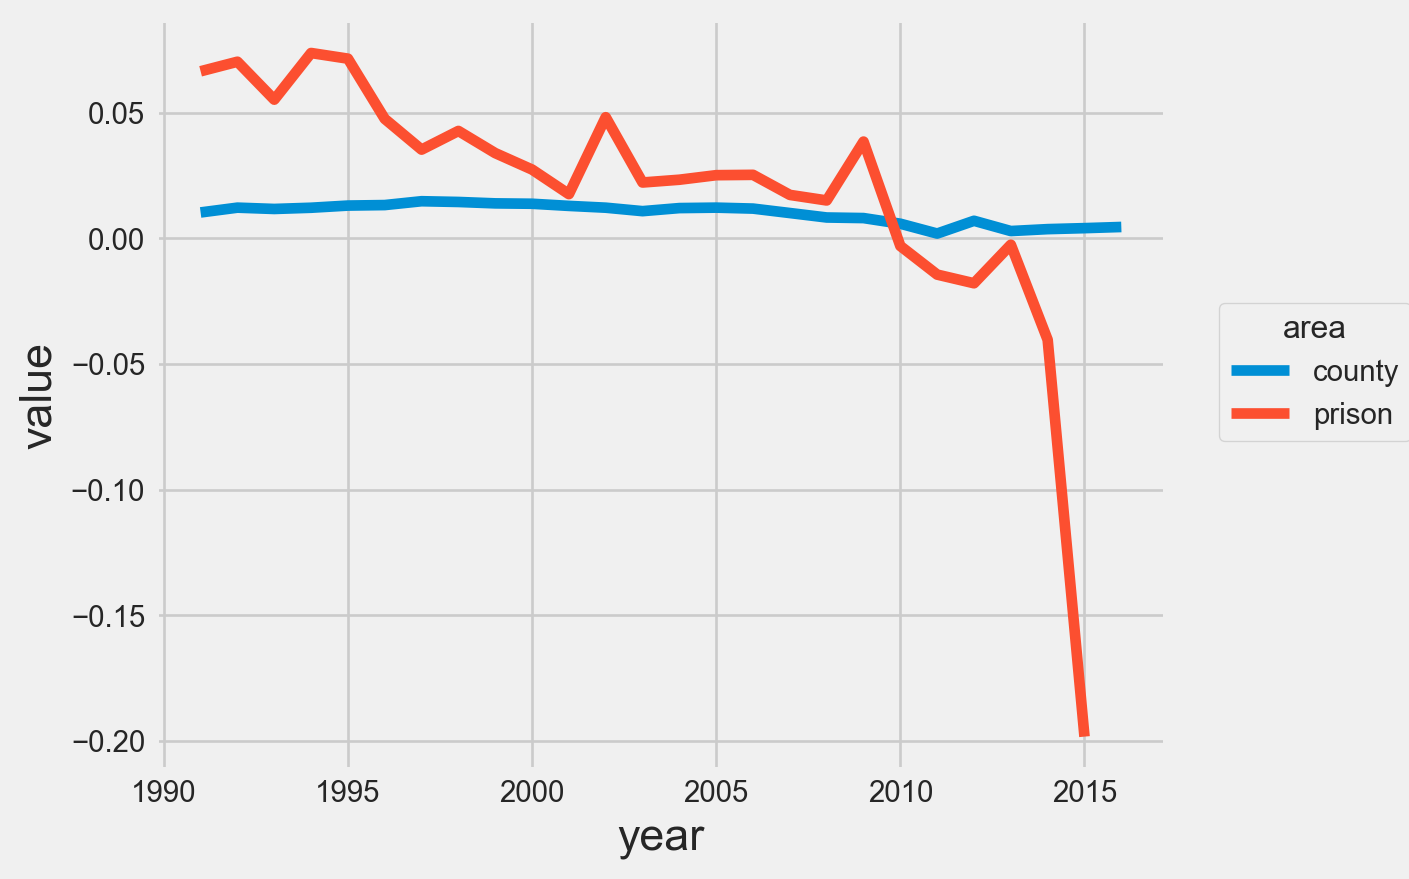

In [12]:
def _plot(df) -> so.Plot:
    return (
        so.Plot(df, x='year', y='value', color='area')
        .add(so.Line())
        .theme({**style.library["fivethirtyeight"]})
    )


(
    v_pop()
    .groupby(['year', 'area'])[['value']].sum()
    .groupby('area')[['value']].pct_change()
    .pipe(_plot)
)

## Schemas

In [14]:
v_source().columns.sort_values().to_list()

['agr_assault_crime',
 'arson_crime',
 'asian_jail_pop',
 'asian_pop_15to64',
 'asian_prison_adm',
 'asian_prison_pop',
 'black_jail_pop',
 'black_pop_15to64',
 'black_prison_adm',
 'black_prison_pop',
 'burglary_crime',
 'capacity',
 'commuting_zone',
 'confined_pop',
 'county_name',
 'division',
 'female_jail_adm_dcrp',
 'female_jail_pop',
 'female_jail_pop_dcrp',
 'female_jail_pretrial',
 'female_pop_15to64',
 'female_prison_adm',
 'female_prison_pop',
 'id',
 'index_crime',
 'jail_from_fed',
 'jail_from_ice',
 'jail_from_other_state_jail',
 'jail_from_other_state_prison',
 'jail_from_state_jail',
 'jail_from_state_prison',
 'land_area',
 'larceny_crime',
 'latino_jail_pop',
 'latino_pop_15to64',
 'latino_prison_adm',
 'latino_prison_pop',
 'male_jail_adm_dcrp',
 'male_jail_pop',
 'male_jail_pop_dcrp',
 'male_jail_pretrial',
 'male_pop_15to64',
 'male_prison_adm',
 'male_prison_pop',
 'metro_area',
 'murder_crime',
 'mv_theft_crime',
 'native_jail_pop',
 'native_pop_15to64',
 'nativ

`v_county`

In [15]:
v_county().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county_id          3139 non-null   int64  
 1   county_short_name  3139 non-null   object 
 2   county_name        3139 non-null   object 
 3   state_id           3139 non-null   int64  
 4   state_short_name   3139 non-null   object 
 5   state_name         3139 non-null   object 
 6   division_id        3139 non-null   int64  
 7   division_name      3139 non-null   object 
 8   region_id          3139 non-null   int64  
 9   region_name        3139 non-null   object 
 10  capacity           3136 non-null   float64
 11  commuting_zone     3138 non-null   float64
 12  land_area          3138 non-null   float64
 13  metro_area         1803 non-null   float64
 14  num_employees      3136 non-null   float64
 15  urbanicity         3139 non-null   object 
dtypes: float64(5), int64(4),

`v_crime`

In [16]:
v_crime().info()

KeyError: "['county_id', 'year'] not in index"

`mv_population`

In [ ]:
mv_population.info()

## Discarded

`mv_admissions`

`v_jail_pop() -> pd.DataFrame`

`v_jail_vector() -> pd.DataFrame`